# Pirate Pain — PCA Feature Analysis

This notebook performs a PCA-driven analysis to identify which engineered features from the multivariate time series are most useful for training a classification model for the **Pirate Pain** dataset.


**NOTEBOOK BY thenegatives**


**Burchini - Collovigh - Corti - Ravasio**

## 0) Setup
Install (if needed) and import dependencies.

In [1]:
import sys, subprocess
def pip_install(pkg):
    try:
        __import__(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

for pkg in ['pandas', 'numpy', 'scikit-learn', 'matplotlib']:
    pip_install(pkg)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import os, math

plt.rcParams['figure.dpi'] = 110

## 1) Load Data
Set paths to your CSVs. Update these if your files are elsewhere.

In [2]:
DATA_DIR = '.'  # change if needed
TRAIN_PATH = os.path.join(DATA_DIR, 'pirate_pain_train.csv')
TRAIN_LABELS_PATH = os.path.join(DATA_DIR, 'pirate_pain_train_labels.csv')
TEST_PATH = os.path.join(DATA_DIR, 'pirate_pain_test.csv')

X_train_ts = pd.read_csv(TRAIN_PATH)
y_train_df = pd.read_csv(TRAIN_LABELS_PATH)
X_test_ts = pd.read_csv(TEST_PATH)

display(X_train_ts.head())
display(y_train_df.head())
display(X_test_ts.head())

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5


,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,low_pain
3,3,no_pain
4,4,no_pain


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,2,2,2,two,two,two,0.842535,...,0.000003,0.000004,0.000003,0.000003,0.000068,0.019372,0.066324,0.022228,0.013576,0.5
1,0,1,2,2,2,2,two,two,two,0.898836,...,0.000003,0.000004,0.000004,0.000003,0.000029,0.069747,0.080417,0.023650,0.038793,0.5
2,0,2,2,2,2,2,two,two,two,0.957765,...,0.000006,0.000004,0.000009,0.000004,0.000008,0.054968,0.058811,0.027023,0.054202,0.5
3,0,3,1,2,2,2,two,two,two,0.832596,...,0.000005,0.000004,0.000003,0.000004,0.000015,0.048695,0.047128,0.016151,0.024983,0.5
4,0,4,2,2,2,0,two,two,two,0.805971,...,0.000006,0.000004,0.000003,0.000003,0.000008,0.019762,0.031116,0.015618,0.017931,0.5


## 2) Basic Sanity Checks

In [3]:
print('Train rows:', len(X_train_ts), ' Test rows:', len(X_test_ts))
print('Unique train samples:', X_train_ts['sample_index'].nunique())
print('Unique test samples:', X_test_ts['sample_index'].nunique())
print('Time steps per sample (train):')
print(X_train_ts.groupby('sample_index')['time'].nunique().describe())
print('\nLabel distribution:')
print(y_train_df['label'].value_counts())

Train rows: 105760  Test rows: 211840
Unique train samples: 661
Unique test samples: 1324
Time steps per sample (train):
count    661.0
mean     160.0
std        0.0
min      160.0
25%      160.0
50%      160.0
75%      160.0
max      160.0
Name: time, dtype: float64

Label distribution:
label
no_pain      511
low_pain      94
high_pain     56
Name: count, dtype: int64


## 3) Feature Engineering

We convert each time series into a fixed-length, per-sample feature vector. For each numeric channel we compute:
- **mean, std, min, max, median, IQR** (Q3 - Q1)
- **trend slope** over time (simple linear regression with time index)

For the categorical channels (`n_legs`, `n_hands`, `n_eyes`) provided as strings (e.g., `"two"`), we will **one-hot encode** their *most frequent value over time* per sample.

This yields a compact representation suitable for PCA and downstream classical ML.


In [4]:
NUMERIC_PREFIXES = [
    'pain_survey_1','pain_survey_2','pain_survey_3','pain_survey_4'
] + [f'joint_{i:02d}' for i in range(31)]
CATEGORICAL_COLS = ['n_legs','n_hands','n_eyes']

def _iqr(x):
    return np.subtract(*np.nanpercentile(x, [75, 25]))

def _slope(y, x=None):
    if x is None:
        x = np.arange(len(y), dtype=float)
    y = np.asarray(y, dtype=float)
    x = np.asarray(x, dtype=float)
    m = np.isfinite(x) & np.isfinite(y)
    x = x[m]
    y = y[m]
    if len(x) < 2:
        return np.nan
    x_mean = x.mean()
    y_mean = y.mean()
    denom = ((x - x_mean)**2).sum()
    if denom == 0:
        return 0.0
    return ((x - x_mean)*(y - y_mean)).sum() / denom

def engineer_features(df):
    # Ensure correct dtypes
    df = df.copy()
    for c in CATEGORICAL_COLS:
        df[c] = df[c].astype('category')
    # Numeric columns (coerce errors)
    for c in NUMERIC_PREFIXES:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    agg_funcs = {
        **{col: ['mean','std','min','max','median'] for col in NUMERIC_PREFIXES},
    }

    # Compute IQR manually and slope separately to keep column names tidy
    grouped = df.groupby('sample_index')
    base = grouped[NUMERIC_PREFIXES].agg(agg_funcs)
    base.columns = ['__'.join(col).strip() for col in base.columns.values]

    # IQR
    iqr_df = grouped[NUMERIC_PREFIXES].apply(lambda g: g.apply(_iqr)).rename(columns=lambda c: f"{c}__iqr")

    # Slope per numeric feature (versus time)
    def slopes(group):
        t = group['time'].values.astype(float)
        out = {}
        for col in NUMERIC_PREFIXES:
            out[f"{col}__slope"] = _slope(group[col].values, t)
        return pd.Series(out)
    slope_df = grouped.apply(slopes)

    # Categorical mode (most frequent) per sample
    cat_mode = grouped[CATEGORICAL_COLS].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    cat_mode = cat_mode.add_prefix('mode__')

    # Merge all
    engineered = base.join([iqr_df, slope_df, cat_mode])
    engineered.reset_index(inplace=True)
    return engineered

engineered_train = engineer_features(X_train_ts)
engineered_test = engineer_features(X_test_ts)

print(engineered_train.shape, engineered_test.shape)
engineered_train.head()

/tmp/ipython-input-1451987319.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slope_df = grouped.apply(slopes)
/tmp/ipython-input-1451987319.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slope_df = grouped.apply(slopes)


(661, 249) (1324, 249)


,sample_index,pain_survey_1__mean,pain_survey_1__std,pain_survey_1__min,pain_survey_1__max,pain_survey_1__median,pain_survey_2__mean,pain_survey_2__std,pain_survey_2__min,pain_survey_2__max,...,joint_24__slope,joint_25__slope,joint_26__slope,joint_27__slope,joint_28__slope,joint_29__slope,joint_30__slope,mode__n_legs,mode__n_hands,mode__n_eyes
0,0,1.61250,0.760565,0,2,2.0,1.65625,0.673365,0,2,...,2.499989e-08,2.125164e-07,0.000054,0.000017,0.000016,0.000043,0.0,two,two,two
1,1,1.60000,0.719888,0,2,2.0,1.69375,0.653937,0,2,...,-9.706342e-10,1.563337e-08,-0.000002,0.000049,0.000085,0.000055,0.0,two,two,two
2,2,1.00625,0.482354,0,2,1.0,0.86875,0.550836,0,2,...,2.714708e-07,8.257372e-07,-0.000576,-0.000585,0.000161,0.000065,0.0,two,two,two
3,3,1.80625,0.520001,0,2,2.0,1.66250,0.671874,0,2,...,-3.112285e-09,8.570815e-08,0.000105,0.000011,-0.000013,0.000005,0.0,two,two,two
4,4,1.74375,0.606535,0,2,2.0,1.75625,0.590777,0,2,...,7.370208e-10,1.462489e-08,0.000054,0.000006,0.000009,0.000008,0.0,two,two,two


## 4) Merge Labels and Split
We stratify by label and keep a validation set for visualization. (PCA remains unsupervised, but the scatter helps sanity-check separability.)

In [5]:
df_all = engineered_train.merge(y_train_df, on='sample_index', how='left')
labels = df_all['label'].astype('category')
X = df_all.drop(columns=['label'])
y = labels

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape, X_valid.shape)
X_train.head()

(528, 249) (133, 249)


,sample_index,pain_survey_1__mean,pain_survey_1__std,pain_survey_1__min,pain_survey_1__max,pain_survey_1__median,pain_survey_2__mean,pain_survey_2__std,pain_survey_2__min,pain_survey_2__max,...,joint_24__slope,joint_25__slope,joint_26__slope,joint_27__slope,joint_28__slope,joint_29__slope,joint_30__slope,mode__n_legs,mode__n_hands,mode__n_eyes
165,165,1.69375,0.653937,0,2,2.0,1.71875,0.616052,0,2,...,6.521303e-10,4.005887e-09,5.904903e-05,-0.000045,1.342821e-05,0.000053,0.0,two,two,two
385,385,1.68750,0.665289,0,2,2.0,1.71250,0.657683,0,2,...,2.121070e-08,-6.513208e-08,8.179998e-05,0.000151,4.419374e-05,-0.000056,0.0,two,two,two
547,547,1.71875,0.626178,0,2,2.0,1.61250,0.709216,0,2,...,-3.141313e-07,2.297372e-06,9.635795e-07,0.000021,-9.875343e-07,-0.000011,0.0,two,two,two
421,421,1.71250,0.657683,0,2,2.0,1.74375,0.574586,0,2,...,1.288815e-09,-1.165453e-08,1.073602e-07,-0.000003,-1.215424e-05,-0.000003,0.0,two,two,two
282,282,1.65625,0.663959,0,2,2.0,1.65000,0.702198,0,2,...,2.747124e-09,8.455128e-09,1.226697e-05,-0.000007,-1.206024e-04,0.000055,0.0,two,two,two


## 5) Preprocess (One-Hot for categorical modes) & PCA
We will:
1. One-hot encode the `mode__n_legs`, `mode__n_hands`, and `mode__n_eyes` columns.
2. Standardize all numeric features.
3. Fit PCA on **train only**; transform both train and valid.

We pick `n_components` to cover up to 95% of explained variance (capped at 50 components for compactness).

In [6]:
cat_mode_cols = ['mode__n_legs','mode__n_hands','mode__n_eyes']
num_cols = [c for c in X_train.columns if c not in cat_mode_cols and c != 'sample_index']

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_mode_cols)
    ], remainder='drop'
)

# fit on train only
Xtr = preprocess.fit_transform(X_train)
Xva = preprocess.transform(X_valid)

# choose n_components for 95% variance (cap at 50)
pca_full = PCA().fit(Xtr)
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
n95 = int(np.searchsorted(cumvar, 0.95) + 1)
n_components = min(50, n95)
print('n_components (95% var, capped at 50):', n_components)

pca = PCA(n_components=n_components).fit(Xtr)
Ztr = pca.transform(Xtr)
Zva = pca.transform(Xva)

# Keep feature names after preprocessing
cat_feature_names = list(preprocess.named_transformers_['cat'].get_feature_names_out(cat_mode_cols))
feature_names = num_cols + cat_feature_names

n_components (95% var, capped at 50): 50


## 6) Plots: Explained Variance & Cumulative Variance

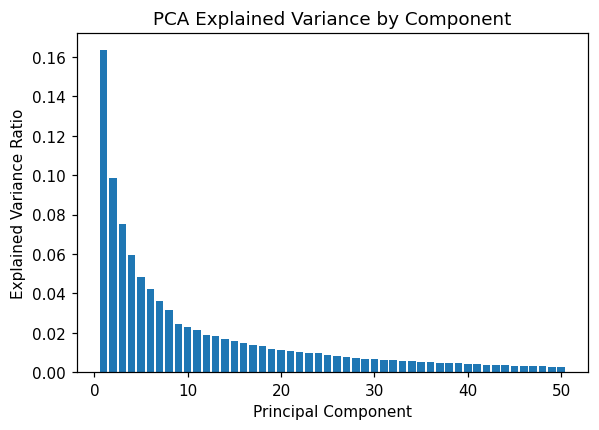

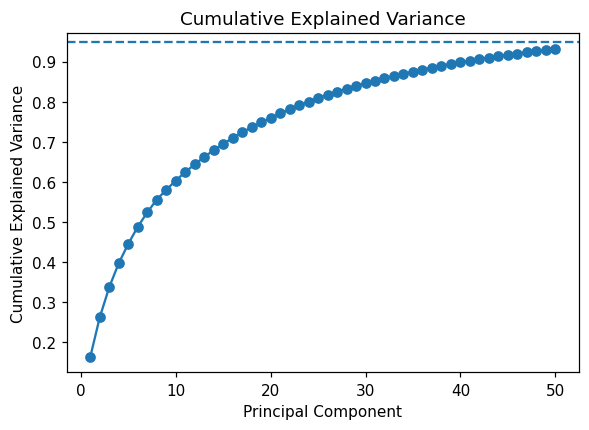

In [7]:
fig1 = plt.figure(figsize=(6,4))
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance by Component')
plt.show()

fig2 = plt.figure(figsize=(6,4))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.axhline(0.95, linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.show()

## 7) 2D Scatter on First Two PCs (Validation Set)
This is only for visualization; PCA is unsupervised.

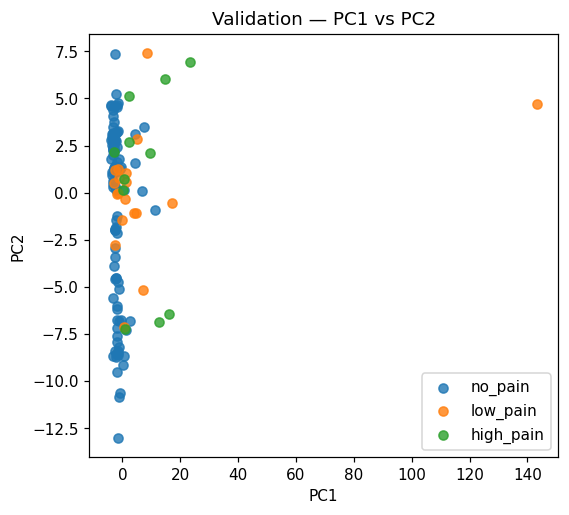

In [8]:
fig3 = plt.figure(figsize=(5.5,5))
pc1 = Zva[:,0]
pc2 = Zva[:,1] if Zva.shape[1] > 1 else np.zeros_like(pc1)
lbls = y_valid.values
classes = pd.unique(lbls)
for c in classes:
    mask = (lbls == c)
    plt.scatter(pc1[mask], pc2[mask], label=str(c), alpha=0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Validation — PC1 vs PC2')
plt.legend()
plt.show()

## 8) Feature Loadings & Variance-Weighted Importance
We compute per-feature contributions as the sum of squared loadings across the top components, weighted by their explained variance ratio. Higher means the feature contributes more to the principal directions capturing the most variance.

In [9]:
loadings = pca.components_  # shape: (n_components, n_features)
expl_var = pca.explained_variance_ratio_.reshape(-1,1)
weighted = (loadings**2) * expl_var  # variance-weighted squared loadings
importance = weighted.sum(axis=0)

feat_importance = (
    pd.DataFrame({'feature': feature_names, 'pca_importance': importance})
      .sort_values('pca_importance', ascending=False)
      .reset_index(drop=True)
)
top20 = feat_importance.head(20)
top20

,feature,pca_importance
0,joint_21__std,0.004380
1,joint_21__max,0.004378
2,joint_22__std,0.004377
3,joint_21__mean,0.004377
4,joint_22__max,0.004376
5,joint_09__mean,0.004374
6,joint_08__mean,0.004374
7,joint_08__median,0.004372
8,joint_09__median,0.004372
9,joint_22__mean,0.004366


## 9) Compact Biplot (PC1 vs PC2)
We show arrows for the **top 10** contributing features to keep the plot readable.

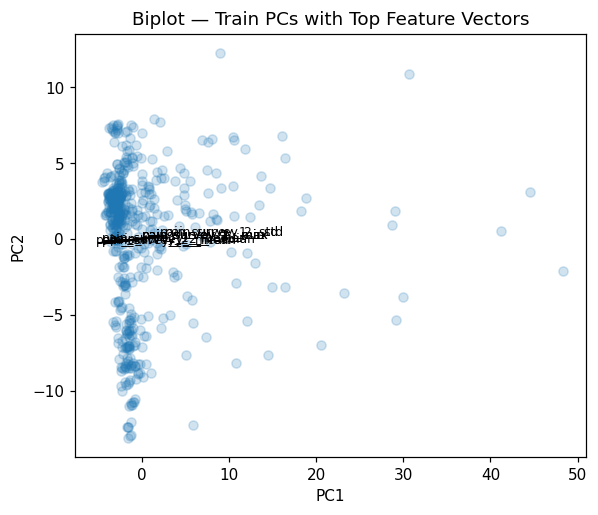

In [10]:
fig4 = plt.figure(figsize=(6,5))
pc1 = Ztr[:,0]
pc2 = Ztr[:,1] if Ztr.shape[1] > 1 else np.zeros_like(pc1)
plt.scatter(pc1, pc2, alpha=0.2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Biplot — Train PCs with Top Feature Vectors')

n_show = min(10, loadings.shape[1])
top_idx = feat_importance.head(n_show).index
for idx in top_idx:
    # Normalize arrow length for visibility
    v1 = loadings[0, idx]
    v2 = loadings[1, idx] if loadings.shape[0] > 1 else 0.0
    plt.arrow(0, 0, v1*max(pc1), v2*max(pc2), head_width=0.05, length_includes_head=True)
    plt.text(v1*max(pc1)*1.05, v2*max(pc2)*1.05, feature_names[idx], fontsize=8)

plt.show()

## 10) Export Artifacts
Save engineered features and PCA diagnostics for downstream modeling.

In [11]:
ENGINEERED_OUT = 'engineered_features.csv'
COMPONENTS_OUT = 'pca_components.csv'
IMPORTANCE_OUT = 'pca_feature_importance.csv'

engineered_train.assign(label=y.values).to_csv(ENGINEERED_OUT, index=False)
pd.DataFrame(pca.components_, columns=feature_names).to_csv(COMPONENTS_OUT, index=False)
feat_importance.to_csv(IMPORTANCE_OUT, index=False)
print('Saved:', ENGINEERED_OUT, COMPONENTS_OUT, IMPORTANCE_OUT)

Saved: engineered_features.csv pca_components.csv pca_feature_importance.csv
